In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Cash-Karp RK integration for multiple coupled derivatives

In [3]:
#define our coupled derivatives to integrate
def dydx(x,y):
    
    #y is a 2 element array, with y[0] set to y & y[1] set to z
    #declare (2-element) array for yderivs --> where dydx (deriv of y) is z, and dzdx (deriv of z, second deriv of y) is -y
    #^ our system of equations to evolve
    
    y_derivs = np.zeros(2)
    
    #dydx = z
    y_derivs[0] = y[1] 
    
    #dzdx = -y
    y_derivs[1] = -1*y[0]
    
    return y_derivs


In [4]:
#define cash-karp multi-variable core
def ck_mv_core(dydx, xi, yi, nv, h):
    #def k arrays for Rk integration until 6th order accurate
    #nv = both variables z&y at the same time
    
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    k5 = np.zeros(nv)
    k6 = np.zeros(nv)
    
    
    #define x at one step
#     x_ipo = xi + h
    
    #declare temporary y array, starting with zeros for z&y, later updated values
    y_temp = np.zeros(nv)
    
    #get ci, aij, bi, bi* values
    c2 = 1/5
    c3 = 3/10
    c4 = 3/5
    c5 = 1
    c6 = 7/8
    
    a21 = 1/5
    a31 = 3/40
    a32 = 9/40
    a41 = 3/10
    a42 = -9/10
    a43 = 6/5
    a51 = -11/54
    a52 = 5/2
    a53 = -70/27
    a54 = 35/27
    a61 = 1631/55296
    a62 = 175/512
    a63 = 575/13824
    a64 = 44275/110592
    a65 = 253/4096
    
    b1 = 37/378
    b2 = 0
    b3 = 250/621
    b4 = 125/594
    b5 = 0
    b6 = 512/1771
    
    b11 = 2825/27648
    b22 = 0
    b33 = 18575/48384
    b44 = 13525/55296
    b55 = 277/14336
    b66 = 1/4
    
    #get k1, then k2, then k3, then k4 values (refinement of grid/updated with steps)
    #then k5, then k6, to use just those two steps, and calc error between them
    #^ wrt to both y &z
    #[:] = all elements in the array
    #get k1 values
    y_derivs = dydx(xi, yi) 
    #^deriv of y, with xi&yi
    k1[:] = h*y_derivs[:]
    
    #update yi array with ytemp array, by adding refinement variables
    #update yderivs by taking derivative of updated xi, ytemp array for nv
    #get next k value with height*updated y derivs for refined grid for rk integration
    y_temp[:] = yi[:] + a21*k1
    y_derivs = dydx(xi + c2*h, y_temp)
    k2[:] = h*y_derivs[:]
    
    y_temp[:] = yi[:] + a31*k1 + a32*k2
    y_derivs = dydx(xi + c3*h, y_temp)
    k3[:] = h*y_derivs[:]
    
    y_temp[:]= yi[:] + a41*k1 + a42*k2 + a43*k3
    y_derivs = dydx(xi + c4*h, y_temp)
    k4[:] = h*y_derivs[:]
    
    y_temp[:] = yi[:] + a51*k1 + a52*k2 + a53*k3 + a54*k4
    y_derivs = dydx(xi + c5*h, y_temp)
    k5[:] = h*y_derivs[:]
    
    y_temp[:] = yi[:] + a61*k1 + a62*k2 + a63*k3 + a64*k4 + a65*k5
    y_derivs = dydx(xi + c6*h, y_temp)
    k6[:] = h*y_derivs[:]
    
    #advance y by step h
    #^equal to yi + weighted sum of all k derivatives
    
    yipo_6 = yi + (b1*k1 + b2*k2 + b3*k3 + b4*k4 + b5*k5 + b6*k6)
    yipo_5 = yi + (b11*k1 + b22*k2 + b33*k3 + b44*k4 + b55*k5 + b66*k6)
    Delta = np.fabs(yipo_6 - yipo_5)
    return yipo_6, Delta
    
    

In [5]:
#def wrapper function stepsize (adaptive step size driver for ck), to carry out the function of the ckmv core
#^adapting size of step h based on error/tolerance between rk5 & 6 steps
def ck_mv_ad(dydx, x_i, y_i, nv, h, tol):
    
    #def safety scale
    SAFETY = 0.9
    H_NEW_FAC = 2.0
    
    #set max # iterations
    imax = 10000
    
    #set iterator
    i = 0
    
    #error array
    Delta = np.full(nv, 2*tol) #(while loop) starts at error above tolerance
    
    #remember step
    h_step = h
    
    #adjust step
    while(Delta.max()/tol>1.0):
        #6 rk step & 5&6 rk error Delta
        y_1, Delta = ck_mv_core(dydx, x_i, y_i, nv, h_step)
        
         
        
        #if error too large, take smaller step
        if(Delta.max()/tol>1.0):
            h_step*= SAFETY*(Delta.max()/tol)**(-0.25)
            
        #check iteration
        if(i>=imax):
            print("too many iterations in ck_mv_ad")
            raise StopIteration("ending after i=",i)
        
        #iterate
        i +=1
        
    #outside while loop, get next (new) step - larger
    h_new = np.fmin(h_step*(Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    #return answer, a new step, and the step we took (finite different steps)
    return y_1, h_new, h_step

    

In [6]:
#def wrapper for ck mv core
def ck_mv(dfdx, a, b, y_a, tol):
    #def starting step
    xi = a
    yi = y_a.copy() #copy y array from before
    
    #initial step
    h = 1.0e-4 *(b-a)
    
    #set max number of iterations
    imax = 10000
    
    #set iteration variable
    i = 0
    
    #set number coupled odes as nv (variables z&y at the same time - via the use of y_a - copy of previous 2-element yi array)
    nv = len(y_a)
    
    #set initial conditions
    x = np.full(1,a)
    y = np.full((1,nv), y_a)
    
    #set flag
    flag = 1
    #loop until we reach the right side
    while(flag):
        #calc y_1, or run the ckmv core
        y_1, h_new, h_step = ck_mv_ad(dydx, xi, yi, nv, h, tol)
        #update step, based on adaptive stepsize driver ck_mv_ad - while loop part
        h = h_new
        
        #prevent an overshoot
        if(xi+h_step>b):
            #if xi+step greater than upper limit, take a smaller step
            h = b-xi
            
            #recalculate y_ipo
            y_1, h_new, h_step = ck_mv_ad(dydx, xi, yi, nv, h, tol)
            
            #break from while loop
            flag = 0
        
        #update values
        xi += h_step
        
        yi[:] = y_1[:]
        
        #add step to the arrays
        x = np.append(x, xi)
        #append yi to the end, delete old y, save ynew into y
        y_1 = np.zeros((len(x), nv))
        y_1[0:len(x)-1, :] = y
        y_1[-1,:] = yi[:]
        del y
        
        y = y_1
        
        #prevent too many iterations
        if(i>=imax):
            print("max iterations reached")
            raise StopIteration("iteration # =",i)
            
        #iterate
        i += 1
        
        #print out some info
        s = "i = %3d\tx = %9.8f\ty = %9.8f\th = %9.8f\tb = %9.8f" % (i, xi, yi[0], h_step, b)
        print(s)
        
        #break if xi = b
        if (xi==b):
            flag = 0
    #outside while loop, return the answer (evolved x&y values)
    return x,y

In [7]:
#perform the ck integration for the 2 coupled derivatives

#bounds (0, 2pi)
a = 0.0
b = 2.0*np.pi

#y array
y_0 = np.zeros(2)
y_0[0] = 0.0 #initially, y(x=0) = 0 = y[0]
y_0[1] = 1.0 #initially, dydx(x=0) = 1 = z = y[1]

#variables to integrate, z&y
nv = 2
tolerance = 1.0e-6

#perform integration analytically
x,y = ck_mv(dydx, a, b, y_0, tolerance)

i =   1	x = 0.00062832	y = 0.00062832	h = 0.00062832	b = 6.28318531
i =   2	x = 0.00188496	y = 0.00188495	h = 0.00125664	b = 6.28318531
i =   3	x = 0.00439823	y = 0.00439822	h = 0.00251327	b = 6.28318531
i =   4	x = 0.00942478	y = 0.00942464	h = 0.00502655	b = 6.28318531
i =   5	x = 0.01947787	y = 0.01947664	h = 0.01005310	b = 6.28318531
i =   6	x = 0.03958407	y = 0.03957373	h = 0.02010619	b = 6.28318531
i =   7	x = 0.07979645	y = 0.07971180	h = 0.04021239	b = 6.28318531
i =   8	x = 0.16022123	y = 0.15953660	h = 0.08042477	b = 6.28318531
i =   9	x = 0.32107077	y = 0.31558279	h = 0.16084954	b = 6.28318531
i =  10	x = 0.64276986	y = 0.59941495	h = 0.32169909	b = 6.28318531
i =  11	x = 0.93739384	y = 0.80601851	h = 0.29462398	b = 6.28318531
i =  12	x = 1.20675386	y = 0.93446544	h = 0.26936002	b = 6.28318531
i =  13	x = 1.49426997	y = 0.99707369	h = 0.28751611	b = 6.28318531
i =  14	x = 1.76344767	y = 0.98150050	h = 0.26917769	b = 6.28318531
i =  15	x = 2.03076151	y = 0.89606839	h = 0.2673

<ipython-input-5-3c1f079e20e5>:41: RuntimeWarning: divide by zero encountered in double_scalars
  h_new = np.fmin(h_step*(Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)


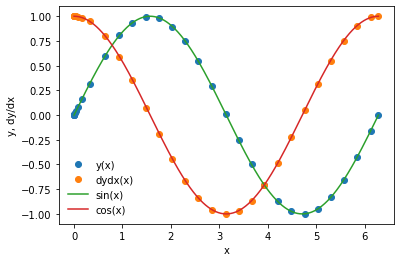

In [8]:
#plot analytical result of x,y against sinx&cosx
plt.plot(x,y[:,0], 'o', label='y(x)')
plt.plot(x,y[:,1], 'o', label='dydx(x)')
xx = np.linspace(0,2.0*np.pi,1000)
plt.plot(xx, np.sin(xx), label='sin(x)')
plt.plot(xx, np.cos(xx), label='cos(x)')
plt.xlabel('x')
plt.ylabel('y, dy/dx')
plt.legend(frameon=False)

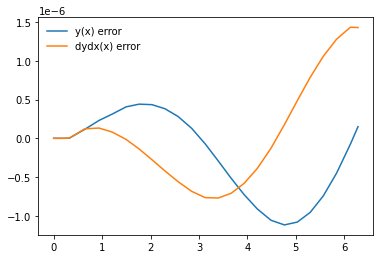

In [9]:
#plot the error
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0]-sine)
dydx_error = (y[:,1]-cosine)

plt.plot(x, y_error, label="y(x) error")
plt.plot(x, dydx_error, label="dydx(x) error")
plt.legend(frameon=False)